# Carte de contrôle

### Connexion a la BDD

In [81]:
import psycopg
import matplotlib.pyplot as plt

params_conn = {
  "host": "localhost",
  "dbname": "db",
  "user": "postgres",
  "password": "patate360",
  "port": 5432
}

conn = psycopg.connect(**params_conn)

### 1 - Cartes de contrôle

33


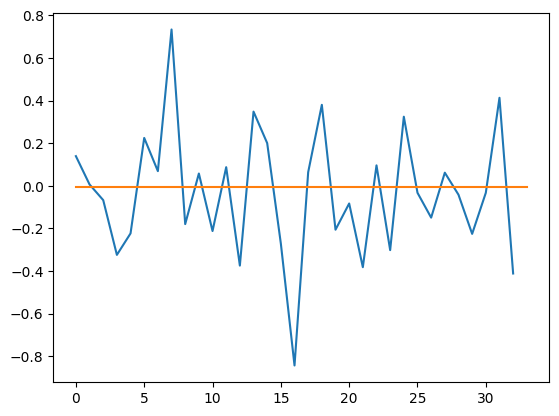

16


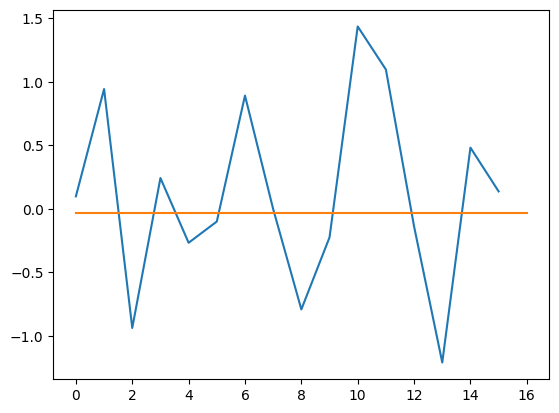

8


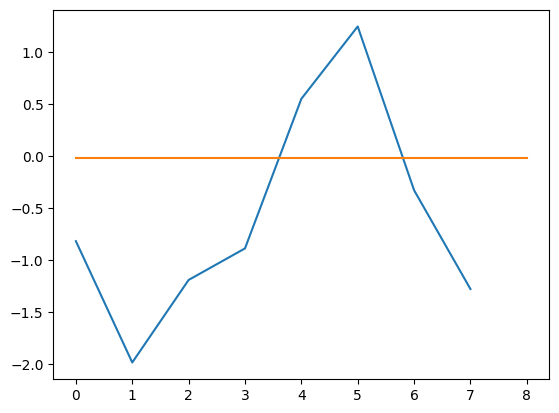

8


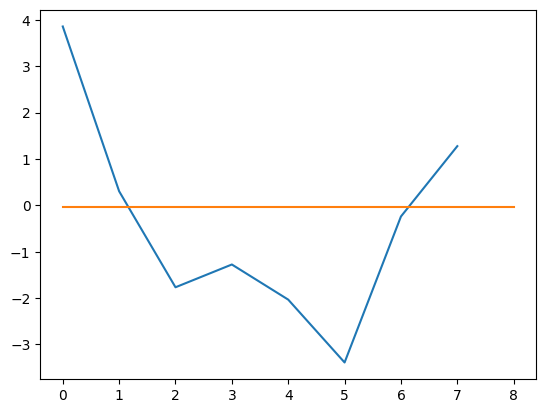

9


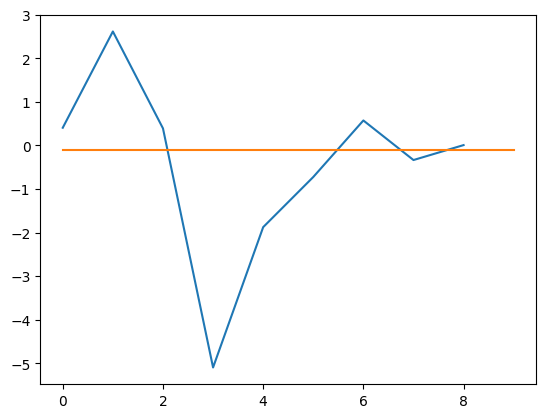

8


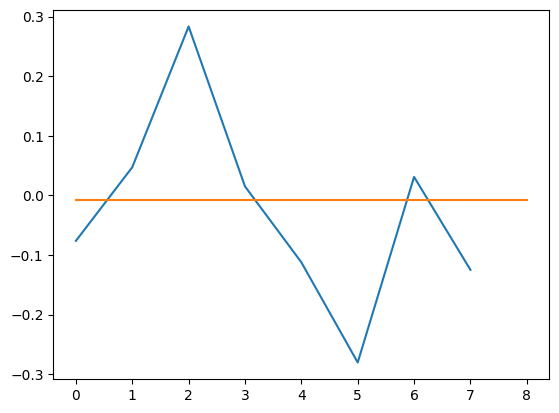

5


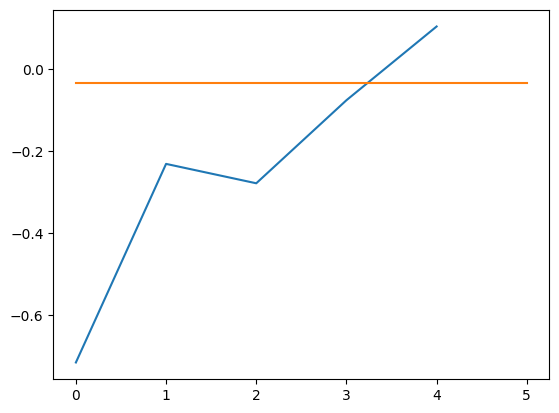

1.658837804399804

In [ ]:
def isSensorExist(conn, idSensor):
  sql = """
  SELECT * FROM Sensor WHERE sensorid = %(id)s 
  """

  param = {"id": idSensor}

  with conn.execute(sql, param) as cur:
    row = cur.fetchone()

    if(row == None):
      return False
    
    return True

def getLastMeasure(conn, idSensor):
  if (not isSensorExist(conn, idSensor)):
    raise Exception("No sensor associated with this id")
  
  sql = """
  SELECT max(controltimestamp) FROM controlMeasurement
  WHERE sensorid = %(id)s 
  """

  param = {"id": idSensor}

  with conn.execute(sql, param) as cur:
    return cur.fetchone()[0]

def getDataControlCard(conn, idSensor):
  if (not isSensorExist(conn, idSensor)):
    raise Exception("No sensor associated with this id")

  lastM = getLastMeasure(conn, idSensor)

  sql = """
  SELECT controlValue - sensorValue
  FROM ControlMeasurement cm
  JOIN SensorMeasurement sm ON cm.sensorid = sm.sensorid AND cm.sensortimestamp = sm.timestamp
  WHERE cm.sensorid = %(id)s AND
    cm.controltimestamp >= %(lastM)s - INTERVAL '8 day' AND
    cm.controltimestamp <= %(lastM)s
  ORDER BY cm.controltimestamp DESC
  LIMIT 100
  """

  param = {"id": idSensor, "lastM": lastM}

  with conn.execute(sql, param) as cur:
    rows = []

    for el in cur:
      rows.append(el[0])

    return rows

def getMean(conn, idSensor):
  if (not isSensorExist(conn, idSensor)):
    raise Exception("No sensor associated with this id")

  sql = """
    SELECT avg(controlValue - sensorValue)
    FROM ControlMeasurement cm
    JOIN SensorMeasurement sm ON cm.sensorid = sm.sensorid AND cm.sensortimestamp = sm.timestamp
    WHERE cm.sensorid = %(id)s;
  """

  param = {"id": idSensor}

  with conn.execute(sql, param) as cur:
    return cur.fetchone()[0]

def getStddev(conn, idSensor):
  if (not isSensorExist(conn, idSensor)):
    raise Exception("No sensor associated with this id")

  sql = """
    SELECT stddev(controlValue - sensorValue)
    FROM ControlMeasurement cm
    JOIN SensorMeasurement sm ON cm.sensorid = sm.sensorid AND cm.sensortimestamp = sm.timestamp
    WHERE cm.sensorid = %(id)s;
  """

  param = {"id": idSensor}

  with conn.execute(sql, param) as cur:
    return cur.fetchone()[0]

def showControlCard(conn, idSensor):
  data = getDataControlCard(conn, idSensor)
  mean = getMean(conn, idSensor)
  stddev = getStddev(conn, idSensor)

  plt.plot(data)
  plt.plot([0, len(data)], [mean, mean])
  plt.plot([0, len(data)], [mean - 2 * stddev, mean - 2 * stddev])
  plt.plot([0, len(data)], [mean + 2 * stddev, mean + 2 * stddev])
  plt.show()

for i in range(1, 8):
  showControlCard(conn, i)
